In [1]:
#from graph import load_graph
import pandas as pd
import networkx as nx
from dowhy.causal_identifier import backdoor
import numpy as np


### Functions

In [2]:
def get_all_possible_paths(graph):
    # Get every path between educ and lwage. Do this being converting the graph to undirected.
    H = graph.to_undirected()

    # the all_simple_paths function finds all possible undirected paths between 'X' and 'Y' in graph H
    all_possible_paths = list(nx.all_simple_paths(H, 'educ', 'lwage'))

    # print("These are all posible paths between educ and lwage.")
    # for path in all_possible_paths:
    #     print(path)

    return all_possible_paths

def get_backdoorpaths(all_possible_paths, graph):
    # Get if path in all_possible_path is a backdoor path.
    bd = backdoor.Backdoor(graph, 'educ', 'lwage')
    backdoor_paths = [path for path in all_possible_paths if bd.is_backdoor(path)]

    # print("These are all backdoor paths.")
    # for path in backdoor_paths:
    #     print(path)

    return backdoor_paths


def get_adjustment_variables(backdoor_paths, graph):
    # Create a dataframe with the paths as rows and for each path the colliders and non-colliders
    adjustment_variables = pd.DataFrame(columns=['path', 'colliders', 'non_colliders'])

    for path in backdoor_paths:
        colliders = np.array([])
        non_colliders = []
        path_len = len(path)
        for node0, node1, node2 in zip(path[0:path_len-2], path[1:path_len-1], path[2:]):
            # if there is an arrow pointing into node1 from both sides on the path, it is a collider
            if graph.has_edge(node0, node1) and graph.has_edge(node2, node1):
                colliders = np.append(colliders, list(nx.descendants(graph,node1)) + [node1]) # so we add it (and all its descendants) to the list

        # we flatten the list of list
        colliders = colliders.flatten()
        non_colliders = [x for x in path[1:-1] if all(x_i != x for x_i in colliders)]

        adjustment_variables.loc[len(adjustment_variables.index)] = [path, colliders, non_colliders] 

    return adjustment_variables  


In [3]:
def backdoor_criterion(graph):
    possible_paths = get_all_possible_paths(graph)
    backdoor_paths = get_backdoorpaths(possible_paths, graph)
    adjustment_variables = get_adjustment_variables(backdoor_paths, graph)
    return adjustment_variables

DoWhy functions

In [4]:
import dowhy
from dowhy import CausalModel
from IPython.display import Image, display

# a utility function to parse the .gml file to string
def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str


def dowhy_backdoor(file):

    # creating arbitrary data
    df = pd.read_stata("data/close_college.dta")

    gml_graph = gml_to_string(file)
    # With GML string
    model=CausalModel(
        data = df,
        treatment='educ',
        outcome='lwage',
        graph=gml_graph
    )

    identified_estimand = model.identify_effect()
    print(identified_estimand)


In [5]:
# a utility function to parse the .gml file to string
def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str

In [6]:
df = pd.read_stata("data/close_college.dta")
display(df.head())
df.shape

,nearc4,educ,black,smsa,south,married,exper,lwage
0,0,7,1,1,0,1.0,16,6.306275
1,0,12,0,1,0,1.0,9,6.175867
2,0,12,0,1,0,1.0,16,6.580639
3,1,11,0,1,0,1.0,10,5.521461
4,1,12,0,1,0,1.0,16,6.591674


### Backdoor criterion - Graph version = 0

In [7]:
from graph import load_graph
import pandas as pd
import networkx as nx

G = load_graph(version=0)
# nx.draw(G, with_labels=True, node_size=1000, font_size=8)


educ -> smsa results in all variables being a descendant of educ

And since descendats cannot be in adjustment set, the backdoor criterion cannot be satisfied. Because there are open backdoor paths between educ an lwage qwithout any variable in the adjustment set Z.

In [8]:
adjustment_variables = backdoor_criterion(G)
display(adjustment_variables)
print(f"Descendants of educ are: {nx.descendants(G,'educ') | {'educ'}}")
print("These variables cannot be included in the adjustment set.")

,path,colliders,non_colliders
0,"[educ, nearc4, smsa, south, black, lwage]",[],"[nearc4, smsa, south, black]"
1,"[educ, nearc4, smsa, black, lwage]",[],"[nearc4, smsa, black]"
2,"[educ, nearc4, smsa, lwage]",[],"[nearc4, smsa]"
3,"[educ, black, lwage]",[],[black]
4,"[educ, black, smsa, lwage]",[],"[black, smsa]"
5,"[educ, black, south, smsa, lwage]",[],"[black, south, smsa]"


Descendants of educ are: {'smsa', 'nearc4', 'exper', 'educ', 'married', 'lwage', 'black', 'south'}
These variables cannot be included in the adjustment set.


**Adjustment set**

Not possible, backdoor criterion is not satisfied.

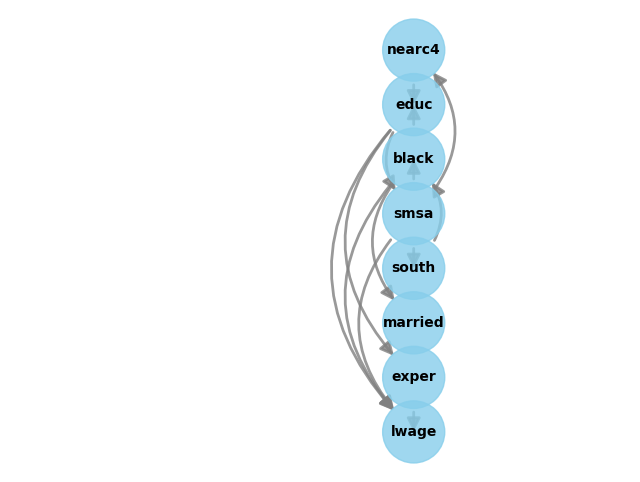

In [9]:
model=CausalModel(
        data = df,
        treatment='educ',
        outcome='lwage',
        graph=G
        )
model.view_model()

In [10]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [11]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

Estimation failed! No relevant identified estimand available for this estimation method.
Causal Estimate is None


### Backdoor criterion - Graph version = 1

In [12]:
from graph import load_graph
import pandas as pd
import networkx as nx
import numpy as np

G = load_graph(version=1)
# nx.draw(G, with_labels=True, node_size=1000, font_size=8)


In [13]:
adjustment_variables = backdoor_criterion(G)
display(adjustment_variables)
print(f"Descendants of educ are: {nx.descendants(G,'educ') | {'educ'}}")
print("These variables cannot be included in the adjustment set.")

,path,colliders,non_colliders
0,"[educ, nearc4, smsa, south, black, lwage]",[],"[nearc4, smsa, south, black]"
1,"[educ, nearc4, smsa, black, lwage]",[],"[nearc4, smsa, black]"
2,"[educ, nearc4, smsa, lwage]",[],"[nearc4, smsa]"
3,"[educ, black, lwage]",[],[black]
4,"[educ, black, smsa, lwage]",[],"[black, smsa]"
5,"[educ, black, south, smsa, lwage]",[],"[black, south, smsa]"


Descendants of educ are: {'lwage', 'exper', 'educ'}
These variables cannot be included in the adjustment set.


**Adjustment sets**

- Minimum: black, nearc4 OR black, smsa

Other posibilities
- black, nearc4
- black, nearc4, smsa
- black, nearc4, south
- black, nearc4, smsa, south


**DoWhy**

In [14]:
import dowhy
from dowhy import CausalModel
from IPython.display import Image, display

# a utility function to parse the .gml file to string
def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str


def dowhy_backdoor(file):

    # creating arbitrary data
    df = pd.read_stata("data/close_college.dta")

    gml_graph = gml_to_string(file)
    # With GML string
    model=CausalModel(
        data = df,
        treatment='educ',
        outcome='lwage',
        graph=gml_graph
    )

    identified_estimand = model.identify_effect()
    print(identified_estimand)

dowhy_backdoor("graph_files/graph_version1.gml")

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                          
───────(E[lwage|nearc4,black])
d[educ]                       
Estimand assumption 1, Unconfoundedness: If U→{educ} and U→lwage then P(lwage|educ,nearc4,black,U) = P(lwage|educ,nearc4,black)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



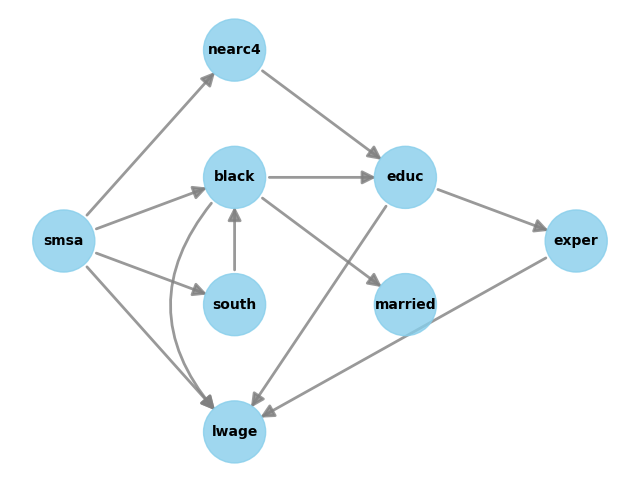

In [15]:
model=CausalModel(
        data = df,
        treatment='educ',
        outcome='lwage',
        graph=G
        )
model.view_model()

In [16]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                          
───────(E[lwage|nearc4,black])
d[educ]                       
Estimand assumption 1, Unconfoundedness: If U→{educ} and U→lwage then P(lwage|educ,nearc4,black,U) = P(lwage|educ,nearc4,black)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [17]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                          
───────(E[lwage|nearc4,black])
d[educ]                       
Estimand assumption 1, Unconfoundedness: If U→{educ} and U→lwage then P(lwage|educ,nearc4,black,U) = P(lwage|educ,nearc4,black)

## Realized estimand
b: lwage~educ+nearc4+black
Target units: ate

## Estimate
Mean value: 0.03908018280075343

Causal Estimate is 0.03908018280075343


C:\Users\Harry\anaconda3\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


#### version 2

In [18]:
from graph import load_graph
import pandas as pd
import networkx as nx
import numpy as np

G = load_graph(version=2)
# nx.draw(G, with_labels=True, node_size=1000, font_size=8)

adjustment_variables = backdoor_criterion(G)
display(adjustment_variables)
print(f"Descendants of educ are: {nx.descendants(G,'educ') | {'educ'}}")
print("These variables cannot be included in the adjustment set.")
dowhy_backdoor("graph_files/graph_version2.gml")


,path,colliders,non_colliders
0,"[educ, nearc4, smsa, black, lwage]",[],"[nearc4, smsa, black]"
1,"[educ, nearc4, smsa, lwage]",[],"[nearc4, smsa]"
2,"[educ, black, lwage]",[],[black]
3,"[educ, black, smsa, lwage]",[],"[black, smsa]"
4,"[educ, smsa, black, lwage]",[],"[smsa, black]"
5,"[educ, smsa, lwage]",[],[smsa]


Descendants of educ are: {'lwage', 'exper', 'educ'}
These variables cannot be included in the adjustment set.
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
───────(E[lwage|smsa,black])
d[educ]                     
Estimand assumption 1, Unconfoundedness: If U→{educ} and U→lwage then P(lwage|educ,smsa,black,U) = P(lwage|educ,smsa,black)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [19]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                          
───────(E[lwage|nearc4,black])
d[educ]                       
Estimand assumption 1, Unconfoundedness: If U→{educ} and U→lwage then P(lwage|educ,nearc4,black,U) = P(lwage|educ,nearc4,black)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [20]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                          
───────(E[lwage|nearc4,black])
d[educ]                       
Estimand assumption 1, Unconfoundedness: If U→{educ} and U→lwage then P(lwage|educ,nearc4,black,U) = P(lwage|educ,nearc4,black)

## Realized estimand
b: lwage~educ+nearc4+black
Target units: ate

## Estimate
Mean value: 0.03908018280075343

Causal Estimate is 0.03908018280075343


C:\Users\Harry\anaconda3\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


## VERSION 3

In [21]:
from graph import load_graph
import pandas as pd
import networkx as nx
import numpy as np

G = load_graph(version=3)
# nx.draw(G, with_labels=True, node_size=1000, font_size=8)

adjustment_variables = backdoor_criterion(G)
display(adjustment_variables)
print(f"Descendants of educ are: {nx.descendants(G,'educ') | {'educ'}}")
print("These variables cannot be included in the adjustment set.")
dowhy_backdoor("graph_files/graph_version3.gml")


,path,colliders,non_colliders
0,"[educ, nearc4, smsa, black, lwage]",[],"[nearc4, smsa, black]"
1,"[educ, nearc4, smsa, black, exper, lwage]",[],"[nearc4, smsa, black, exper]"
2,"[educ, nearc4, smsa, lwage]",[],"[nearc4, smsa]"
3,"[educ, black, lwage]",[],[black]
4,"[educ, black, exper, lwage]",[],"[black, exper]"
5,"[educ, black, smsa, lwage]",[],"[black, smsa]"
6,"[educ, smsa, black, lwage]",[],"[smsa, black]"
7,"[educ, smsa, black, exper, lwage]",[],"[smsa, black, exper]"
8,"[educ, smsa, lwage]",[],[smsa]


Descendants of educ are: {'lwage', 'exper', 'educ'}
These variables cannot be included in the adjustment set.
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
───────(E[lwage|smsa,black])
d[educ]                     
Estimand assumption 1, Unconfoundedness: If U→{educ} and U→lwage then P(lwage|educ,smsa,black,U) = P(lwage|educ,smsa,black)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [22]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                          
───────(E[lwage|nearc4,black])
d[educ]                       
Estimand assumption 1, Unconfoundedness: If U→{educ} and U→lwage then P(lwage|educ,nearc4,black,U) = P(lwage|educ,nearc4,black)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [23]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                          
───────(E[lwage|nearc4,black])
d[educ]                       
Estimand assumption 1, Unconfoundedness: If U→{educ} and U→lwage then P(lwage|educ,nearc4,black,U) = P(lwage|educ,nearc4,black)

## Realized estimand
b: lwage~educ+nearc4+black
Target units: ate

## Estimate
Mean value: 0.03908018280075343

Causal Estimate is 0.03908018280075343


C:\Users\Harry\anaconda3\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


# Version 4

In [27]:
import dowhy
from dowhy import CausalModel
from IPython.display import Image, display

# a utility function to parse the .gml file to string
def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str


def dowhy_backdoor(file):

    # creating arbitrary data
    df = pd.read_stata("data/close_college.dta")

    gml_graph = gml_to_string(file)
    # With GML string
    model=CausalModel(
        data = df,
        treatment='educ',
        outcome='lwage',
        graph=gml_graph
    )

    identified_estimand = model.identify_effect()
    print(identified_estimand)

In [28]:
from graph import load_graph
import pandas as pd
import networkx as nx

G = load_graph(version=4)
#nx.draw(G, with_labels=True, node_size=1000, font_size=8)

In [29]:
gml_graph = gml_to_string('graph_files/graph_version4.gml')

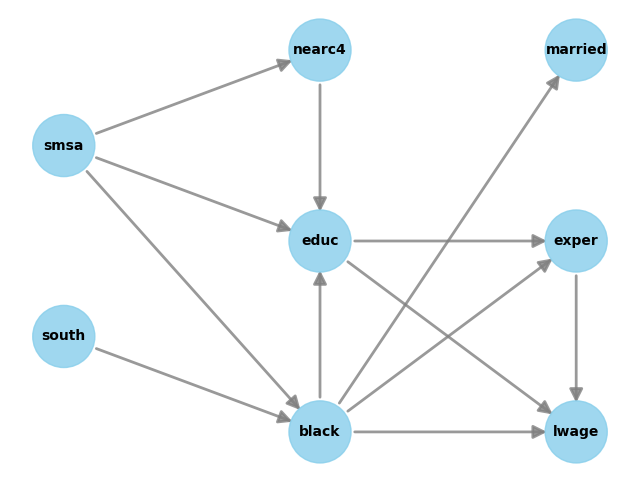

In [30]:
model=CausalModel(
        data = df,
        treatment='educ',
        outcome='lwage',
        graph=gml_graph
        )
model.view_model()

In [31]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                   
───────(E[lwage|black])
d[educ]                
Estimand assumption 1, Unconfoundedness: If U→{educ} and U→lwage then P(lwage|educ,black,U) = P(lwage|educ,black)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [32]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                   
───────(E[lwage|black])
d[educ]                
Estimand assumption 1, Unconfoundedness: If U→{educ} and U→lwage then P(lwage|educ,black,U) = P(lwage|educ,black)

## Realized estimand
b: lwage~educ+black
Target units: ate

## Estimate
Mean value: 0.0415694059713001

Causal Estimate is 0.0415694059713001


C:\Users\Harry\anaconda3\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


# Version 5

In [33]:
from graph import load_graph
import pandas as pd
import networkx as nx

G = load_graph(version=5)
#nx.draw(G, with_labels=True, node_size=1000, font_size=8)

In [34]:
gml_graph = gml_to_string('graph_files/graph_version5.gml')

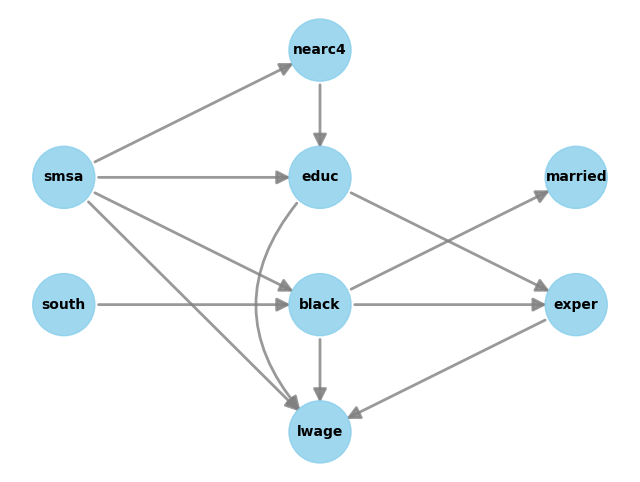

In [35]:
model=CausalModel(
        data = df,
        treatment='educ',
        outcome='lwage',
        graph=gml_graph
        )
model.view_model()

In [36]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                  
───────(E[lwage|smsa])
d[educ]               
Estimand assumption 1, Unconfoundedness: If U→{educ} and U→lwage then P(lwage|educ,smsa,U) = P(lwage|educ,smsa)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [37]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                  
───────(E[lwage|smsa])
d[educ]               
Estimand assumption 1, Unconfoundedness: If U→{educ} and U→lwage then P(lwage|educ,smsa,U) = P(lwage|educ,smsa)

## Realized estimand
b: lwage~educ+smsa+educ*black+educ*south
Target units: 

## Estimate
Mean value: 0.03525438294474981
### Conditional Estimates
__categorical__black  __categorical__south
(-0.001, 1.0]         (-0.001, 1.0]           0.035254
dtype: float64
Causal Estimate is 0.03525438294474981


C:\Users\Harry\anaconda3\Lib\site-packages\dowhy\causal_estimator.py:236: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_effect_mods = data.groupby(effect_modifier_names)
C:\Users\Harry\anaconda3\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
